In [1]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(3515)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
np.random.seed(3515)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)


### PCA - by svd

In [4]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [5]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [7]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
X2D_using_svd = X2D


### PCA by scikit

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [10]:
X3D_inv = pca.inverse_transform(X2D)
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [11]:
pca.components_

array([[-0.95830753, -0.22691461, -0.17365607],
       [ 0.26542319, -0.93198   , -0.24690851]])

### kernel PCA

In [16]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=3515)

In [17]:
from sklearn.decomposition import KernelPCA


In [18]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

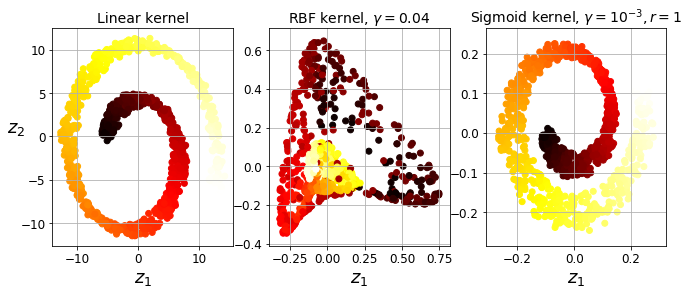

In [19]:

from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)


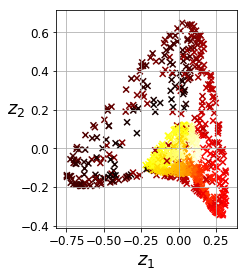

In [21]:

X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="liblinear"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...ty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
print(grid_search.best_params_)


{'kpca__gamma': 0.04555555555555556, 'kpca__kernel': 'rbf'}


In [25]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)


from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

31.655697398986188

### LLE

In [26]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=3515)

In [27]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

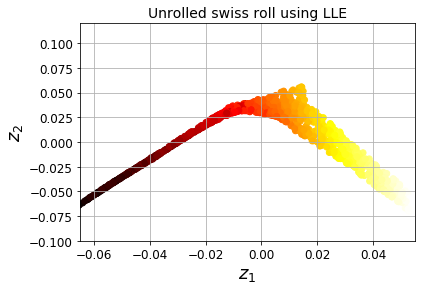

In [28]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
